In [65]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import dvu
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import neuro.features.feature_utils
import joblib
import neuro.data.story_names
import neuro.data.response_utils
from tqdm import tqdm
import neuro.features.feature_spaces
from himalaya.ridge import RidgeCV
from sklearn.model_selection import check_cv
from himalaya.backend import set_backend
import neuro.config
from tabpfn import TabPFNRegressor
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from neuro.features.questions.gpt4 import QS_35_STABLE
from neuro.features import qa_questions
import dvu
dvu.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
subject = 'UTS03'

In [ ]:
story_names_train = neuro.data.story_names.get_story_names(
    subject=subject, train_or_test='train')
story_names_test = neuro.data.story_names.get_story_names(
    # could set use_huge=True here and below....
    subject=subject, train_or_test='test')

In [ ]:
class A:
    feature_space = 'qa_embedder'
    ndelays = 4
    pc_components = 100
    qa_questions_version = 'v3_boostexamples_merged'
    qa_embedding_model = 'ensemble2'
    single_question_idx = -1
    feature_selection_alpha = -1


# load feats, already trimmed and normalized
args = A()
feats_test = neuro.features.feature_utils.get_features_full(
    args=args,
    feature_space=args.feature_space,
    qa_embedding_model=args.qa_embedding_model,
    story_names=story_names_train + story_names_test,
    use_added_delays=False,
)
# compute pairwise correlations between cols of feats_test
sims = cosine_similarity(feats_test.T)
print('sims shape', sims.shape)
joblib.dump(sims, 'sims.pkl')

In [35]:
sims = joblib.load('sims.pkl')
# set diag to 0
np.fill_diagonal(sims, 0)

means 0.508160565377214 0.7011906341358417


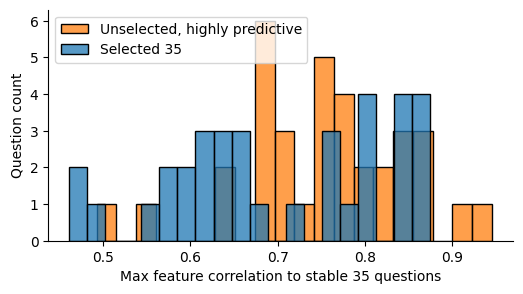

In [74]:
qs = qa_questions.get_merged_questions_v3_boostexamples()
top_qs = pd.read_pickle(
    'corrs_df/single_question_corrs.pkl').sort_values(by='corrs_test_mean', ascending=False).question.values[:70]

idxs_35 = np.array([qs.index(q) for q in QS_35_STABLE])
# idxs_not_35 = np.array([i for i in range(len(qs)) if i not in idxs_35])
idxs_not_35 = np.array([qs.index(q)
                        for q in top_qs if not q in QS_35_STABLE])[:35]

best_sim_35 = sims[:, idxs_35].max(axis=1)
plt.figure(figsize=(6, 3))
sns.histplot(best_sim_35[idxs_not_35], bins=20,
             label='Unselected, highly predictive', color='C1')
sns.histplot(best_sim_35[idxs_35], bins=20, label='Selected 35', color='C0')
print('means', best_sim_35.mean(), best_sim_35[idxs_35].mean())
plt.xlabel('Max feature correlation to stable 35 questions')
plt.ylabel('Question count')
plt.legend()
plt.savefig('question_similarity_in_top_35_hist.pdf', bbox_inches='tight')